In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

SUBSET_LEN = 11
SHIFT_RECORDS = 16 # конец выборки + 6
storm_wind_speed = 10
DPI = 80
FIGSIZE, FIGSIZE_LONG = (10, 6), (12, 6)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('axes', labelsize=20)

In [21]:
source_subsets_df = pd.read_csv("source_subsets_{}.csv".format(storm_wind_speed), index_col=0)
N_subsets = len(source_subsets_df)

In [22]:
mask_4_7 = (source_subsets_df.count_storm == 4) & (source_subsets_df.count_calm == 7)
fraq_4_7 = len(source_subsets_df[mask_4_7])
mask_5_6 = (source_subsets_df.count_storm == 5) & (source_subsets_df.count_calm == 6)
fraq_5_6 = len(source_subsets_df[mask_5_6])
mask_6_5 = (source_subsets_df.count_storm == 6) & (source_subsets_df.count_calm == 5)
fraq_6_5 = len(source_subsets_df[mask_6_5])
mask_7_4 = (source_subsets_df.count_storm == 7) & (source_subsets_df.count_calm == 4)
fraq_7_4 = len(source_subsets_df[mask_7_4])

p1 = fraq_4_7 / N_subsets # вероятность распределение дней как (4, 7)
p2 = fraq_5_6 / N_subsets # вероятность распределение дней как (5, 6)
p3 = fraq_6_5 / N_subsets # вероятность распределение дней как (6, 5)
p4 = fraq_7_4 / N_subsets # вероятность распределение дней как (7, 4)

storm_days_cnt = np.array([4, 5, 6, 7])
storm_days_proba = np.array([p1, p2, p3, p4]) 

print(storm_wind_speed, fraq_4_7, fraq_5_6, fraq_6_5, fraq_7_4, N_subsets)
(fraq_4_7 + fraq_5_6 + fraq_6_5 + fraq_7_4) == N_subsets

10 130140 122492 112221 93799 458652


True

In [ ]:
def getRandomSubsetsDataframe(coordinates, dates, shift_dates=SHIFT_RECORDS, shift_coordinates=0):
    random_rows_list = []
    storms_file = open("data files/storms_{}.txt".format(storm_wind_speed), "r")
    index = 0
    for line in storms_file:
        if index % 50000 == 0:
            print(index)
        cur_storm = list(map(int, line.split()))
        i, j = cur_storm[2], cur_storm[3]
        if i + shift_coordinates >= len(coordinates) or j + shift_dates + SUBSET_LEN > len(dates):
            continue
        k = 0
        while k < SUBSET_LEN and not np.isnan(sea_df.iloc[i + shift_coordinates, j + shift_dates + k]):
            k += 1
        if k < SUBSET_LEN:
            continue
        random_rows_list.append([i + shift_coordinates, j + shift_dates])
        index += 1

    storms_file.close()
    return pd.DataFrame(random_rows_list, columns=["coordinates_index", "start_date_index"])

random_subsets_df = getRandomSubsetsDataframe(coordinates, dates)

In [ ]:
random_subsets_df

In [ ]:
def getMeanSlaDifference(index):
    i, j = random_subsets_df.iloc[index, 0], random_subsets_df.iloc[index, 1] # уже сдвинуты
    count_storm = random.choices(storm_days_cnt, storm_days_proba)[0] # count_calm = 11 - count_storm 

    random_storms = np.random.choice(np.arange(SUBSET_LEN), count_storm, replace=False)
    random_storms_indexes = np.zeros(SUBSET_LEN, dtype=bool)
    random_storms_indexes[random_storms] = True

    mean_storm_sla = sea_df.iloc[i, j:j + SUBSET_LEN][random_storms_indexes].mean()
    mean_calm_sla = sea_df.iloc[i, j:j + SUBSET_LEN][~random_storms_indexes].mean()
    return mean_storm_sla - mean_calm_sla

meanSlaDiff = np.vectorize(getMeanSlaDifference)

In [ ]:
tests_number = 1000
random_sla_diff = []
for i in range(tests_number):
    cur_sla_diff = meanSlaDiff(random_subsets_df.index)
    random_sla_diff.append(cur_sla_diff) # sla_diff для i-го теста
    print(i)

In [ ]:
random_sla_file = open("random_sla_diff_{}_{}.txt".format(storm_wind_speed, SHIFT_RECORDS), "w")
for i in range(tests_number):
    print(" ".join(map(str, random_sla_diff[i])), file=random_sla_file)
random_sla_file.close()
random_sla_diff = np.array(random_sla_diff) # shape  = (tests_number, N_subsets)

In [11]:
start_a = dict({6.7: 0.05, 10: 0.015, 15: 0.0}) # [start_a, 0.5] с шагом 0.005

In [12]:
def getProbabilityDifference(values, a_array): # P[X >= a] - P[X <= -a]
    return np.array([((values >= a).sum() - (values <= -a).sum()) / values.size for a in a_array])

def getExpectationDifference(values, cur_a, delta): # P[a < X < a + delta] - P[-a - delta < X < -a]
    p_plus_a = ((values >= cur_a) & (values <= cur_a + delta)).sum() / values.size
    p_minus_a =((values >= -cur_a - delta) & (values <= -cur_a)).sum() / values.size
    return p_plus_a - p_minus_a

def findExpectation(values, a): # sum_{a} a_i \cdot \Delta p(a)
    expectation = 0.0
    for i in range(len(a) - 1):
        expectation += a[i] * getExpectationDifference(values, a[i], a[i + 1] - a[i])
    return expectation

In [24]:
for shift in (0, 16):
    for storm_wind in (6.7, 10, 15):
        read_file_name = "data files/random_sla_diff_{}_{}.txt".format(storm_wind, shift)
        read_file = open(read_file_name, "r")
        write_random_expectations = open("data files/random_exp_{}_{}.txt".format(storm_wind, shift), "w")
        write_random_proba_diff = open("data files/random_proba_{}_{}.txt".format(storm_wind, shift), "w")

        a = np.arange(start_a[storm_wind], 0.5001, 0.005)
        for line in read_file:
            cur_sla_diff = np.array(list(map(float, line.split())))
            print(findExpectation(cur_sla_diff, a), file=write_random_expectations)
            print(" ".join(map(str, getProbabilityDifference(cur_sla_diff, a))), 
                  file=write_random_proba_diff)

        read_file.close()
        write_random_expectations.close()
        write_random_proba_diff.close()
        print("Done: shift = ", shift, ", storm wind speed = ", storm_wind, sep="")

Done: shift = 0, storm wind speed = 6.7
Done: shift = 0, storm wind speed = 10
Done: shift = 0, storm wind speed = 15
Done: shift = 16, storm wind speed = 6.7
Done: shift = 16, storm wind speed = 10
Done: shift = 16, storm wind speed = 15


In [19]:
abs_max_dict = dict({6.7: 1.2519796221428572, 10: 0.8886879635714285, 15: 0.6027853860714285})

In [20]:
def PrintSlaDiffHist(sla_diff, storm_wind):
    #fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
    abs_max = abs_max_dict[storm_wind]
    n_bins = 200
    (y, bins, _) = plt.hist(sla_diff, bins=n_bins, density=True, range=(-abs_max, abs_max), color="xkcd:maroon")
    x = np.array([(bins[i + 1] + bins[i]) / 2 for i in range(len(bins) - 1)])
    return x, y

def GetSlaErrorExpectation(sla_diff, storm_wind):
    x, y = PrintSlaDiffHist(sla_diff, storm_wind)
    test_x = x[(x >= 0) & (x <= 0.4)]
    test_red = y[(x >= 0) & (x <= 0.4)]
    test_x_reverse = np.flip(x[(x < 0) & (x >= -0.4)])
    test_blue_reverse = np.flip(y[(x < 0) & (x >= -0.4)])

    eps = 1e-15
    mean_y = []
    for i in range(2, len(test_x) - 2):
        sla_diff_expectation = 0.0
        sum_density = 0.0
        for j in range(i - 2, i + 3):
            sla_diff_expectation += (test_red[j] - test_blue_reverse[j]) * test_x[j]
            sum_density += test_red[j] + test_blue_reverse[j]
        mean_y.append(sla_diff_expectation / sum_density)
    return mean_y

1 62
2 62
3 62
4 62
5 62
6 62
7 62
8 62
9 62
10 62
11 62
12 62
13 62
14 62
15 62
16 62
17 62
18 62
19 62
20 62
21 62
22 62
23 62
24 62
25 62
26 62
27 62
28 62
29 62
30 62
31 62
32 62
33 62
34 62
35 62
36 62
37 62
38 62
39 62
40 62
41 62
42 62
43 62
44 62
45 62
46 62
47 62
48 62
49 62
50 62
51 62
52 62
53 62
54 62
55 62
56 62
57 62
58 62
59 62
60 62
61 62
62 62
63 62
64 62
65 62
66 62
67 62
68 62
69 62
70 62
71 62
72 62
73 62
74 62
75 62
76 62
77 62
78 62
79 62
80 62
81 62
82 62
83 62
84 62
85 62
86 62
87 62
88 62
89 62
90 62
91 62
92 62
93 62
94 62
95 62
96 62
97 62
98 62
99 62
100 62
101 62
102 62
103 62
104 62
105 62
106 62
107 62
108 62
109 62
110 62
111 62
112 62
113 62
114 62
115 62
116 62
117 62
118 62
119 62
120 62
121 62
122 62
123 62
124 62
125 62
126 62
127 62
128 62
129 62
130 62
131 62
132 62
133 62
134 62
135 62
136 62
137 62
138 62
139 62
140 62
141 62
142 62
143 62
144 62
145 62
146 62
147 62
148 62
149 62
150 62
151 62
152 62
153 62
154 62
155 62
156 62
157 62
158 62
15

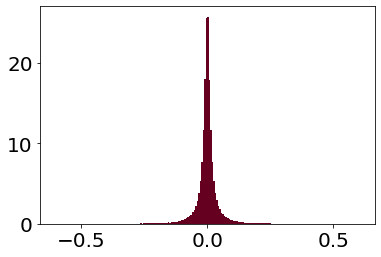

In [21]:
shift = 16
for storm_wind in [15]:
    read_file_name = "data files/random_sla_diff_{}_{}.txt".format(storm_wind, shift)
    read_file = open(read_file_name, "r")
        
    write_sla_error = open("data files/random_sla_error_{}.txt".format(storm_wind), "w")
    cnt = 0
    for line in read_file:
        sla_diff = np.array(list(map(float, line.split())))
        sla_error = GetSlaErrorExpectation(sla_diff, storm_wind)
        print(" ".join(map(str, sla_error)), file=write_sla_error)
        cnt += 1
        print(cnt, len(sla_error))
        
    write_sla_error.close()
    read_file.close()
    print("Done: storm wind speed =", storm_wind)